In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import math
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from torch.distributions import constraints

from physics import compute_penetration_profile
from scipy import constants
from scipy import stats
from configs import respiratorA, temperature, viscosity

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 90

plt.style.use('ggplot')

Now set the seeds:

In [2]:
seed = 43
np.random.seed(seed)
pyro.set_rng_seed(seed)

# pyro.enable_validation()

Now we define the probabilistic model for the respirator, using deterministic parameters except for the charge density which is given a Gamma prior:
$$
    q \sim \Gamma(\alpha, \beta)
$$
We add multiplicative observation noise for the penetration: $P_{obs}(d_p) = P_{model}(d_p)\times \exp(\epsilon)$ where $\epsilon$ is a Gaussian.

In [3]:
# prior distribution on q
theta = 6 * constants.nano
beta = 1./theta
alpha = 5
# We use a Gamma prior -- take care in Pyro Gamma is parameterized using (alpha, beta) !
charge_prior = dist.Gamma(alpha, beta)

def model(diameters):
    charge = pyro.sample('q', charge_prior)
    # print(charge)
    surface_area, layer_params = respiratorA(charge)
    
    debit = 85 * constants.liter / constants.minute
    face_vel = debit / surface_area
    
    results = compute_penetration_profile(
        diameters, layer_params, face_vel, temperature, viscosity)
    obs_scale = 0.2
    with pyro.plate('diameters'):
        # import ipdb; ipdb.set_trace()
        # add heteroskedastic noise
        obs_log = pyro.sample('obs_log', dist.Normal(results.log(), obs_scale))
        obs = pyro.deterministic('obs', obs_log.exp())
    return obs, obs_log

In [4]:
# Particle size range
particle_diam = torch.linspace(math.log(10), math.log(1000), 51)
particle_diam.exp_()
particle_diam.mul_(constants.nano);

We load the data and plot it, as well as the prior model:

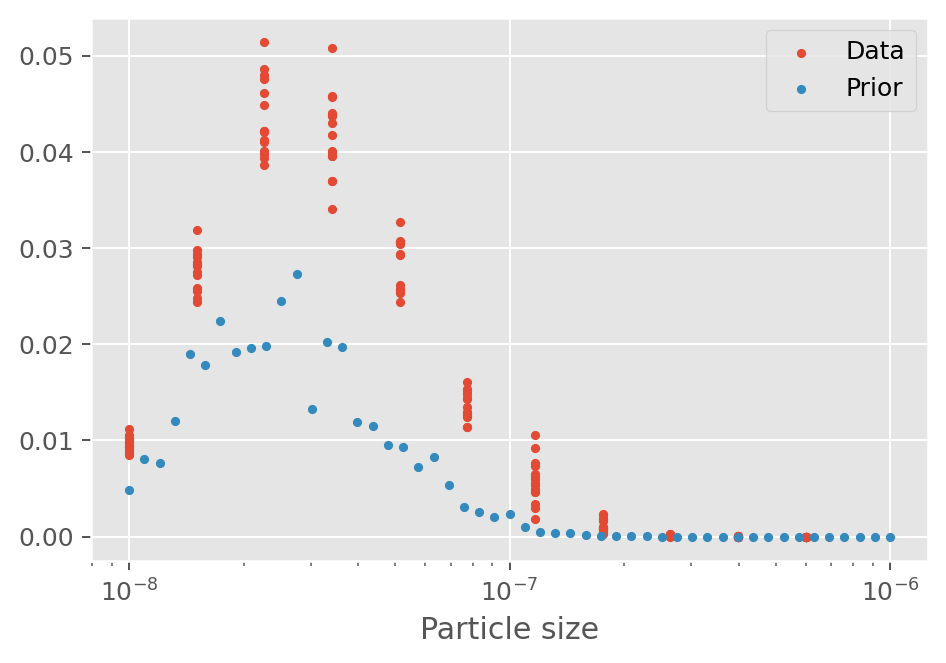

In [7]:
import pandas as pd
import json

# Load the data
filename = "data/synthetic_respA_batch15.csv"
perf_data = pd.read_csv(filename, index_col=0)
data_diameters = torch.from_numpy(perf_data.index.values)
perf_data = torch.from_numpy(perf_data.values).T

with open("data/synthetic_summary.json") as f:
    metadata = json.load(f)[filename]

plt.scatter(data_diameters.repeat(perf_data.shape[0], 1),
            perf_data, s=10, label="Data")
plt.scatter(particle_diam, model(particle_diam)[0].detach(), s=10, label="Prior")
plt.xlabel('Particle size')
plt.legend()
plt.xscale('log')

Then, the synethetic data for penetration $\{P^m(d_i)\}_i$ at multiple particle sizes $d_i$ and samples $m$, are used to condition the model.

In [8]:
# Define a runnable conditioned model
with pyro.plate("data"):
    cond_model = pyro.condition(model, data={'obs_log': perf_data.log()})

## Variational inference

In [9]:
def guide(diameters):
    '''Normal variational posterior.'''
    q_loc = pyro.param('q_loc', torch.tensor(30e-9), constraint=constraints.positive)
    q_std = pyro.param('q_std', torch.tensor(5e-9), constraint=constraints.positive)
    charge = pyro.sample('q', dist.Normal(q_loc, q_std))
    
    surface_area, layer_params = respiratorA(charge)
    
    debit = 85 * constants.liter / constants.minute
    face_vel = debit / surface_area
    
    results = compute_penetration_profile(
        diameters, layer_params, face_vel, temperature, viscosity)
    obs_scale = 0.2
    with pyro.plate('diameters'):
        # import ipdb; ipdb.set_trace()
        obs_log = pyro.sample('obs_log', dist.Normal(results.log(), obs_scale))
        obs = pyro.deterministic('obs', obs_log.exp())
    return obs, obs_log

In [10]:
svi = pyro.infer.SVI(cond_model, guide, pyro.optim.Adam({'lr': 0.08}),
                     loss=pyro.infer.Trace_ELBO())

In [11]:
num_iters = 5000
for i in range(num_iters):
    elbo_ = svi.step(data_diameters)
    if (i+1) % 500 == 0:
        print("Step {:d} ELBO: {:.3g}".format(i, elbo_))

Step 0 ELBO: 4.24e+04
Step 500 ELBO: 1.48e+03
Step 1000 ELBO: 1.49e+03
Step 1500 ELBO: 1.48e+03
Step 2000 ELBO: 1.49e+03
Step 2500 ELBO: 1.49e+03
Step 3000 ELBO: 1.48e+03
Step 3500 ELBO: 1.48e+03
Step 4000 ELBO: 1.49e+03
Step 4500 ELBO: 1.48e+03


In [12]:
num_samples = 1000
predictive_svi = pyro.infer.Predictive(model, guide=guide, num_samples=num_samples)

In [13]:
prediction_dict = predictive_svi(data_diameters)

prediction_dict.keys()

dict_keys(['q', 'obs_log', 'obs'])

In [14]:
pred_svi_q = prediction_dict['q'].detach().flatten()
q_prior_samples = charge_prior.sample((num_samples,))

In [15]:
def plot_prior(fig: plt.Figure, q_prior_samples, q_post_samples):

    gap = q_post_samples.max() - q_post_samples.min()
    qrange = torch.linspace(0, q_post_samples.max()+.2*gap)[1:]
    
    probs = torch.exp(charge_prior.log_prob(qrange))
    
    p, = plt.plot(qrange, probs,
             label="Prior distribution")
    prior_color = p.get_color()
    
    plt.hist(q_prior_samples, bins=n_bins, rwidth=.8, density=True,
             label="Prior samples", color=prior_color, alpha=.8)

In [16]:
n_bins = int(num_samples ** (1/2))

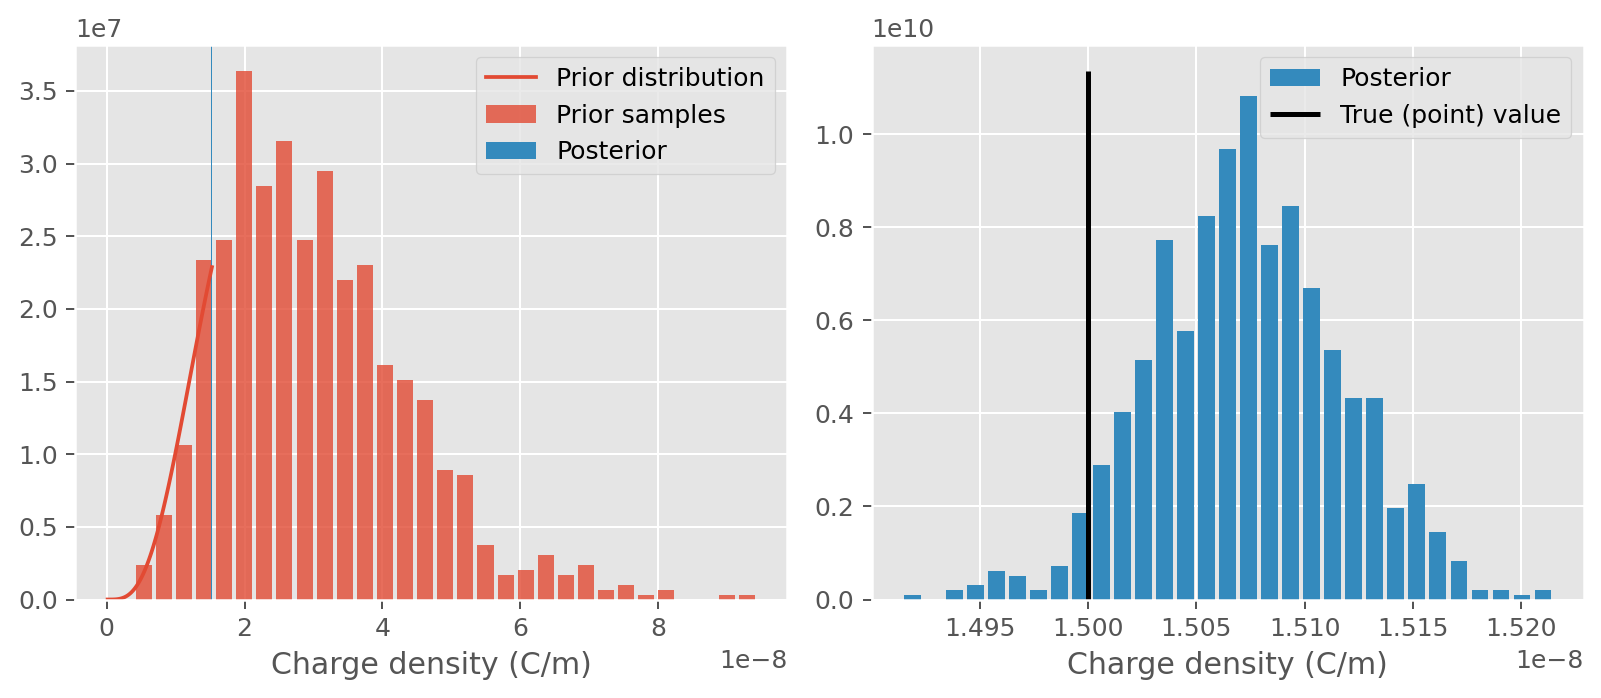

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

plt.sca(ax[0])
plot_prior(fig, q_prior_samples, pred_svi_q)
ylims = plt.ylim()
plt.hist(pred_svi_q, bins=n_bins, rwidth=.8, density=True,
         label="Posterior")
plt.ylim(*ylims)
plt.legend()
plt.xlabel("Charge density (C/m)")
plt.sca(ax[1])
# plot the posterior distribution histogram of the charge density
plt.hist(pred_svi_q, bins=n_bins, rwidth=.8, density=True,
         label="Posterior", color='C1')
true_charge = metadata.get("true_charge", None)
ylims = plt.ylim()
if true_charge is not None:
    plt.vlines(true_charge, *ylims, ls='-', lw=2, label="True (point) value")

plt.xlabel("Charge density (C/m)")
plt.legend()
plt.tight_layout()

In [18]:
#fig.savefig('assets/inference_example_charge_posterior_SVI.png')

In [19]:
prediction_dict_big = predictive_svi(particle_diam)

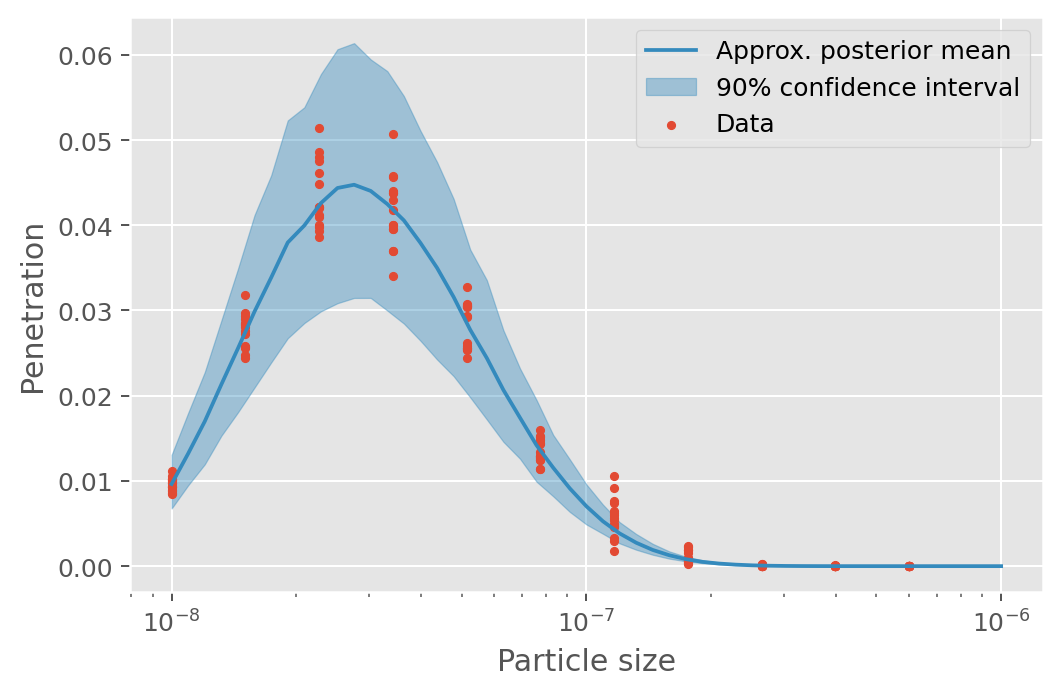

In [20]:
fig = plt.figure()

pred_obs_low, pred_obs_high = pyro.ops.stats.quantile(prediction_dict_big['obs'][:, 0], (0.05, 0.95))
pred_obs_low = pred_obs_low.detach()
pred_obs_high = pred_obs_high.detach()

plt.plot(particle_diam, torch.mean(prediction_dict_big['obs'][:,0].detach(), 0),
            label="Approx. posterior mean", color='C1')
plt.fill_between(particle_diam, pred_obs_low, pred_obs_high,
                 label="90% confidence interval", color='C1', alpha=.4)
plt.scatter(data_diameters.repeat(len(perf_data), 1), perf_data, s=10, label="Data")

plt.xscale('log')
plt.xlabel("Particle size")
plt.ylabel("Penetration")
plt.legend()
plt.tight_layout()

In [21]:
#fig.savefig('assets/prediction_SVI.png')

## MCMC

In [ ]:
## Doesn't converge for some reason
num_samples = 1000
num_chains = 1
kernel = pyro.infer.NUTS(cond_model)
mcmc = pyro.infer.MCMC(kernel, num_samples, num_chains=num_chains)
mcmc.run(data_diameters)

In [ ]:
# Collect our MCMC run data
samples_post = mcmc.get_samples()

q_post_samples = samples_post['q']
gap = q_post_samples.max() - q_post_samples.min()
qrange = torch.linspace(0, q_post_samples.max()+.2*gap)[1:]

In [ ]:
q_prior_samples = charge_prior.sample((num_samples,))
n_bins = int(num_samples ** (1/2))

plt.figure()

probs = torch.exp(charge_prior.log_prob(qrange))

p, = plt.plot(qrange, probs,
         label="Prior distribution")
prior_color = p.get_color()
plt.hist(q_prior_samples, bins=n_bins, rwidth=.8, density=True,
         label="Prior samples", color=prior_color, alpha=.8)

# plot the posterior distribution histogram of the charge density
plt.hist(q_post_samples, bins=n_bins, rwidth=.8, density=True,
         label="Posterior")
ylim = plt.ylim()

plt.vlines(q_post_samples.mean(0), *ylim, label="Posterior mean", color='b')
plt.legend()
plt.title("Prior and posterior of the charge density")
plt.xlabel("Charge density (C/m)")
plt.tight_layout()
plt.show()

## Prediction using the posterior samples

In [ ]:
predictive = pyro.infer.Predictive(model, posterior_samples=samples_post)

In [ ]:
pred_ = []
for ind in pyro.plate("qpost", q_post_samples.shape[0]):
    pred_.append(pyro.condition(model, data={'q': q_post_samples[ind]})(data_diameters))

In [ ]:
pred_ = torch.stack(pred_)

In [ ]:
predictions_dict = predictive(data_diameters)

In [ ]:
pred_obs = predictions_dict['obs']
pred_obs_low, pred_obs_high = pyro.ops.stats.quantile(pred_obs, (0.2, 0.8))

In [ ]:
plt.scatter(data_diameters.repeat(num_samples, 1), pred_obs, s=10)
plt.plot(data_diameters, pred_obs.mean(0))
plt.fill_between(data_diameters, pred_obs_low, pred_obs_high, alpha=.2)
plt.xscale("log")
plt.tight_layout()